# Transfer Learning NASNetMobile terhadap dataset Clothing 10.000

Berikut adalah jupyter notebook untuk transfer learning terhadap arsitektur NASNetMobile tersebut supaya bisa digunakan untuk memprediksi dataset Clothing 10.000.

## Clothing 10.000

Clothing 10.000 adalah sebuah dataset yang dikumpulkan oleh penelitin dengan melakukan proses pengumpulan gambar-gambar dari situs e-commerce secara manual. Dataset ini terdiri dari 10 kelas, masing-masing terdiri dari 1.000 data untuk training dan 250 data untuk testing. Total terdiri dari 12.500 data.

## Langkah Fine Tuning

Secara garis besar, berikut adalah langkah fine tuning yang dilakukan pada penelitian ini:
1. Image augmentation untuk data training dan validation
2. Instansiasi arsitektur model dari keras, dan menghilangkan top layer-nya
3. Menambahkan beberapa layer untuk menggantikan top layer aslinya
4. Set-up fine tuning
5. Training model
6. Testing model

Berikut langkah-langkah tersebut

In [1]:
import os, sys, glob, datetime, time, pytz

from keras import __version__

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
# Defining variables
EPOCHS        = 100
BAT_SIZE      = 20
DATA_SET_DIR  = '/home/jupyter/clothing-dataset/data/' # clothing dataset 10.
MODEL_NAME    = 'NASNetMobile'

WIDTH, HEIGHT = 224, 224
FC_SIZE       = 256
DROPOUT       = 0.5

TRAIN_DIR        = DATA_SET_DIR + 'train'
TEST_DIR         = DATA_SET_DIR + 'test'
nb_classes       = len(glob.glob(TRAIN_DIR + "/*"))

timezone = pytz.timezone("Asia/Jakarta")

now = timezone.localize(datetime.datetime.now())

## 1. Image augmentation untuk data training dan validation

Di bawah ini adalah langkah pertama yang dilakukan.

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Training Sample


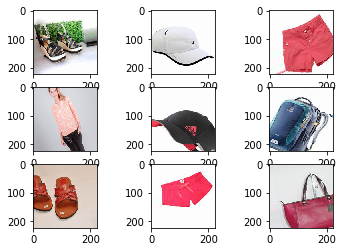

Validation Sample


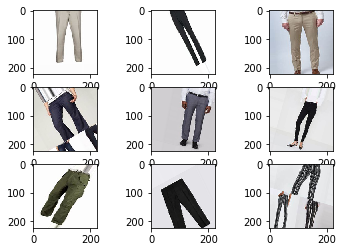

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen =  ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    subset='validation',
    shuffle=False
)

print('Training Sample')
x,y = train_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

print('Validation Sample')
x,y = validation_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

## 2. Instansiasi arsitektur model dari keras, dan menghilangkan top layer-nya

Berikutnya adalah instansiasi arsitektur model aslinya. Model aslinya sendiri sudah tersedia secara built-in di dalam keras. Maka dari itu proses instansiasi-nya menjadi sangat sederhana.

Berikut adalah proses instansiasi tersebut

In [4]:
from keras.applications.nasnet import NASNetMobile

from keras.utils.vis_utils import plot_model

base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

print('Model tanpa top layer terdiri dari %d layer' % len(base_model.layers))

W0717 08:35:02.500499 140031485232576 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 08:35:02.540949 140031485232576 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 08:35:02.545129 140031485232576 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0717 08:35:02.570570 140031485232576 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0717 08:35:02.572932

Model tanpa top layer terdiri dari 769 layer


## 3. Simpan bottleneck features

Pada langkah ini, bottleneck features dari model asli yang sudah di training ke imagenet akan disimpan.

Berikut adalah langkah tersebut

In [5]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.utils.np_utils import to_categorical

train_file_is_exist = os.path.isfile(MODEL_NAME + '_train.npy')
if train_file_is_exist == False:
    print('File ' + MODEL_NAME + '_train.npy tidak ditemukan. Menyimpan...')
    bottleneck_features_train = base_model.predict_generator(train_generator, train_generator.samples // BAT_SIZE)
    np.save(open(MODEL_NAME + '_train.npy', 'w'),bottleneck_features_train)
    print('Tersimpan')
else:
    print('File ' + MODEL_NAME + '_train.npy ditemukan')

validation_file_is_exist = os.path.isfile(MODEL_NAME + '_validation.npy')
if validation_file_is_exist == False:
    print('File ' + MODEL_NAME + '_validation.npy tidak ditemukan. Menyimpan...')
    bottleneck_features_validation = base_model.predict_generator(validation_generator, validation_generator.samples // BAT_SIZE)
    np.save(open(MODEL_NAME + '_validation.npy', 'w'),bottleneck_features_validation)
    print('Tersimpan')
else:
    print('File ' + MODEL_NAME + '_validation.npy ditemukan')

File NASNetMobile_train.npy ditemukan
File NASNetMobile_validation.npy ditemukan


## 4. Load bottleneck features yang sudah disimpan sebelumnya

Langkah ini dilakukan untuk memuat bottleneck features dan menjadikannya numpy array.

Berikut adalah langkahnya.

In [6]:
num_classes = len(train_generator.class_indices)

# train_data = np.load(open(MODEL_NAME + '_train.npy'))
with open(MODEL_NAME + '_train.npy') as train:
    train_data = np.load(train)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

# validation_data = np.load(open(MODEL_NAME + '_validation.npy'))
with open(MODEL_NAME + '_validation.npy') as validation:
    validation_data = np.load(validation)
validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

## 5. Buat layer baru untuk klasifikasi

Layer baru ini akan di training menggunakan weight dari bottleneck features

In [7]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(FC_SIZE, activation='relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

W0717 08:36:06.369067 140031485232576 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0717 08:36:06.399506 140031485232576 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## 5. Training model

Langkah berikutnya adalah training model yang telah di set-up pada langkah sebelumnya.

Berikut adalah langkahnya

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

training_start_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
start = time.time()
history = model.fit(train_data, train_labels,
          epochs=EPOCHS,
          batch_size=BAT_SIZE,
          validation_data=(validation_data, validation_labels))
end = time.time()
training_end_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
print('Training from %s to %s taking %d seconds.' % (training_start_datetime, training_end_datetime, (end - start)))

W0717 08:36:06.890141 140031485232576 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 15s 2ms/step - loss: 14.4507 - acc: 0.0975 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/100
8000/8000 [==============================] - 9s 1ms/step - loss: 14.3890 - acc: 0.1019 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/100
8000/8000 [==============================] - 9s 1ms/step - loss: 14.4562 - acc: 0.1020 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/100
8000/8000 [==============================] - 9s 1ms/step - loss: 14.3989 - acc: 0.1030 - val_loss: 13.2981 - val_acc: 0.1635
Epoch 5/100
8000/8000 [==============================] - 9s 1ms/step - loss: 14.4458 - acc: 0.1000 - val_loss: 13.2376 - val_acc: 0.1745
Epoch 6/100
8000/8000 [==============================] - 9s 1ms/step - loss: 14.4226 - acc: 0.1018 - val_loss: 14.4383 - val_acc: 0.1015
Epoch 7/100
8000/8000 [==============================] - 9s 1ms/step - loss: 14.4817 - acc: 0.0989 - val_loss: 13.4249 - val_acc:

## Langkah Tambahan: Simpan model

In [9]:
model.save(MODEL_NAME + '.model')
print('Model ' + MODEL_NAME + '.model. Tersimpan.')

Model NASNetMobile.model. Tersimpan.


## Langkah tambahan: Tampilkan accuracy, loss, confusion matrix serta classification report

Langkah ini dilakukan untuk menampilkan kurva accuracy dan loss dari training yang telah dilakukan. Serta confusion matrix untuk testing. Selain itu detail laporan terkait precision, f-score dan recall juga ditampilkan di sini.

Berikut adalah langkahnya

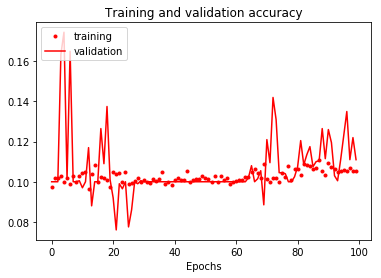

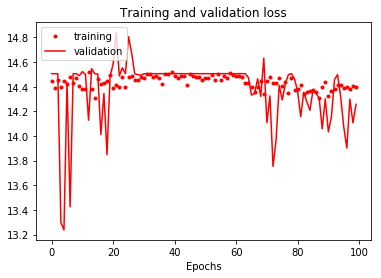

In [10]:
import itertools
from sklearn.utils.multiclass import unique_labels

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r.', label='training')
plt.plot(epochs, val_acc, 'r', label='validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

# Loss
plt.plot(epochs, loss, 'r.', label='training')
plt.plot(epochs, val_loss, 'r-', label='validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()